In [1]:
import gym
import gym.wrappers
from gym.wrappers import RecordEpisodeStatistics
import os
from Algorithms import *
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Health_Env
from Health_Env import *

In [2]:
env = gym.make('HealthcareEnv-v0')

In [3]:
def conv(a, win=100):
    return np.convolve(a, np.ones(win), mode='same') / win

In [4]:
# Hyperparameters
learning_rate = 0.01
episodes = 10000
epsilon = 1.0
epsilon_decay = epsilon / (episodes / 2)  # reduce exploration over time
final_epsilon = 0.1
gamma = 0.95

## Q-learning Agent

In [6]:
agent = HealthQLearnVFA(env, learning_rate, epsilon, epsilon_decay, final_epsilon, gamma)

In [5]:
nenv = RecordEpisodeStatistics(env, deque_size=episodes)

In [9]:
budget_queue = []
for episode in tqdm(range(episodes)):
    observation, info = nenv.reset()
    done = False
    while not done:
        action = agent.policy(observation)
        s_prime, reward, terminated, truncated, info = nenv.step(action = action)
        agent.update(observation, action, reward, s_prime)
        done = terminated or truncated
        observation = s_prime
    agent.decay_epsilon()
    budget_queue.append(reward)

  0%|          | 0/10000 [00:00<?, ?it/s]

c:\Users\miche\RL-Healthcare\.conda\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 10000/10000 [03:51<00:00, 43.22it/s]


In [10]:
def plt_results_(env, agent_, w):
    sns.set_theme(style="whitegrid")
    rewards = conv(np.array(env.return_queue).flatten(), win=w)
    lengths = conv(np.array(env.length_queue).flatten(), win=w)
    error = conv(np.array(agent_.training_error).flatten(), win=w)

    fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
    sns.lineplot(x=range(len(rewards)), y=rewards, ax=ax[0], color='blue', linewidth=.4)
    ax[0].set_title('Reward (Average)')
    sns.lineplot(x=range(len(lengths)), y=lengths, ax=ax[1], color='blue', linewidth=.4)
    ax[1].set_title('Episode Length')
    sns.lineplot(x=range(len(error)), y=error, ax=ax[2], color='blue', linewidth=.2)
    ax[2].set_title('Error')
    for axis in ax:
        axis.tick_params(axis='x', labelsize=8)
        axis.tick_params(axis='y', labelsize=8)
    plt.tight_layout()
    plt.show()

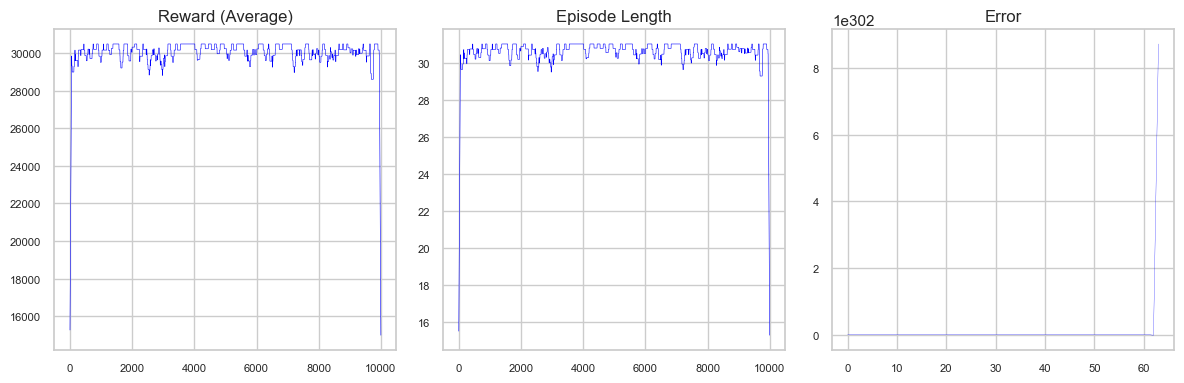

In [11]:
plt_results_(nenv, agent, 100)

#### 1) Goal
###### Explore how the optimal policy changes under different scenarios (in particular with respect to the probability of health risk increment and different discount factors)


In [5]:
discount_factors = [0.9, 0.95, 0.99]
risk_increment_probs = [0.1, 0.2, 0.3]
n_episodes = 1000
learning_rate = 0.001

In [6]:
state, info = env.reset()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:59<00:00, 16.80it/s]


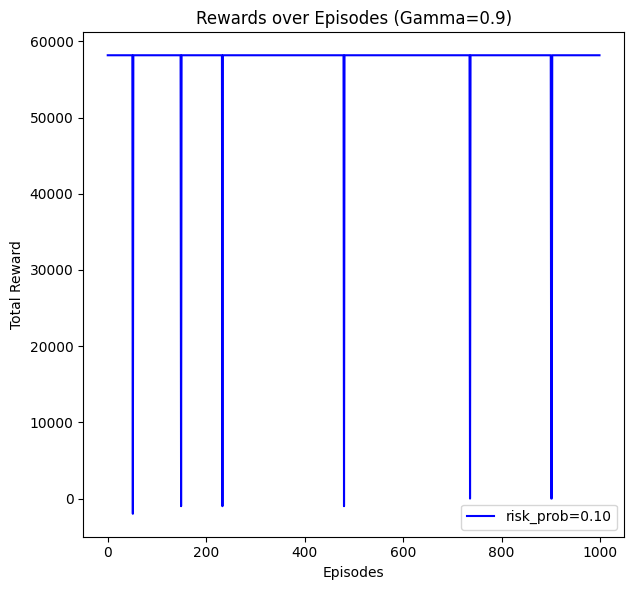

100%|██████████| 1000/1000 [01:10<00:00, 14.09it/s]


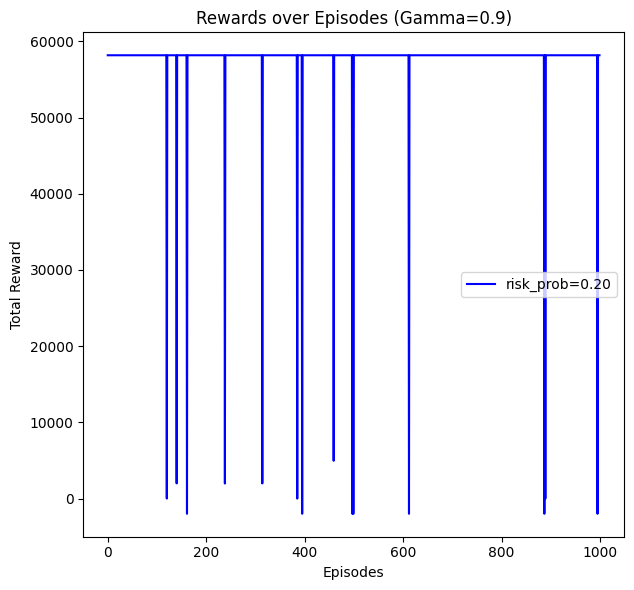

100%|██████████| 1000/1000 [00:45<00:00, 21.81it/s]


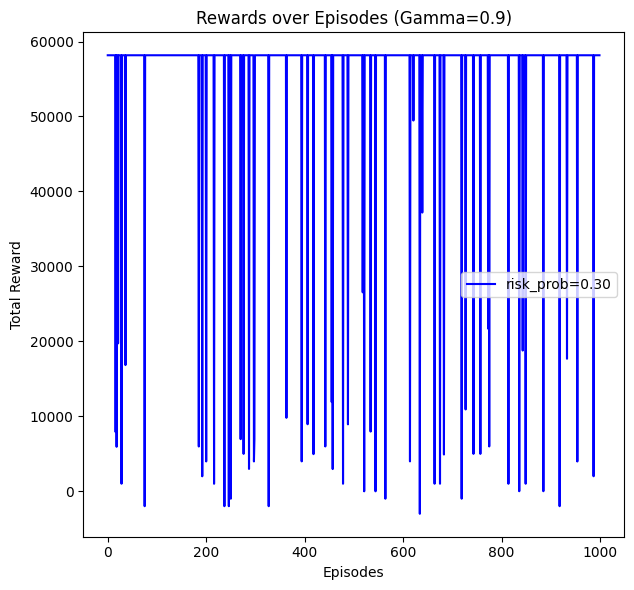

100%|██████████| 1000/1000 [00:50<00:00, 19.73it/s]


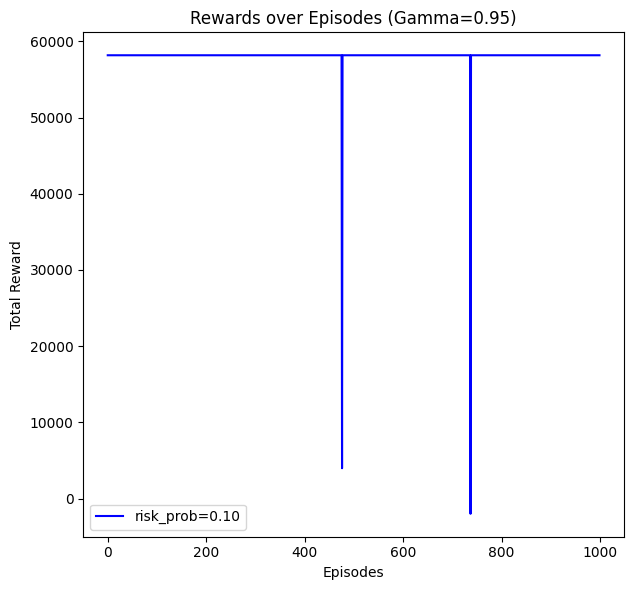

100%|██████████| 1000/1000 [01:08<00:00, 14.69it/s]


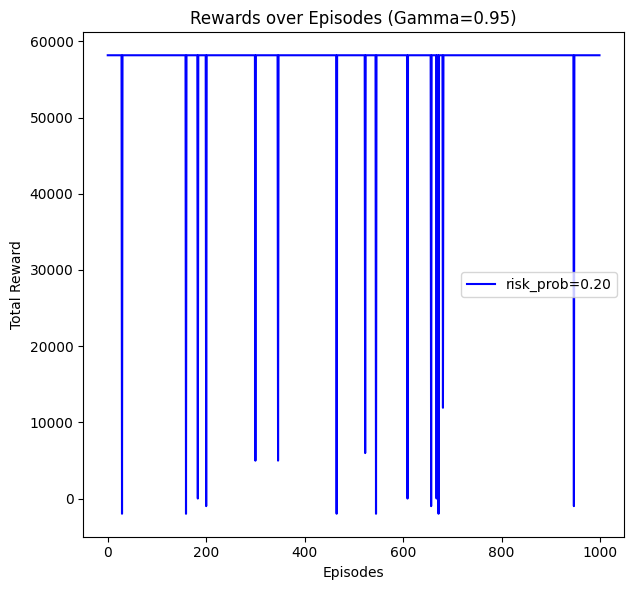

100%|██████████| 1000/1000 [01:13<00:00, 13.68it/s]


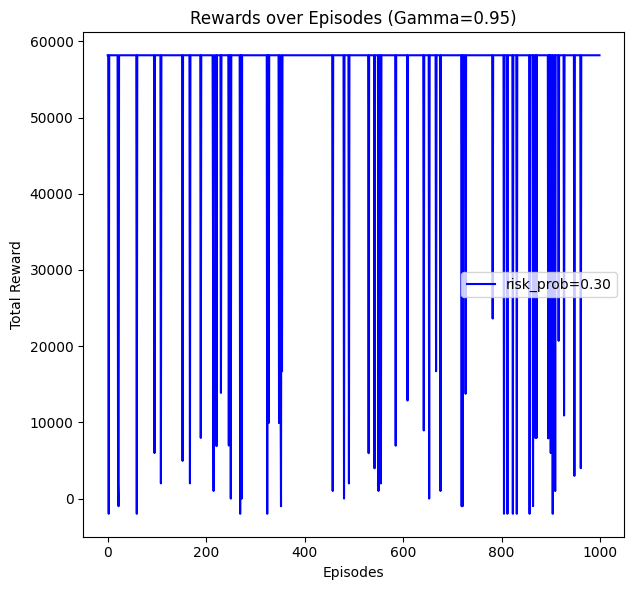

100%|██████████| 1000/1000 [01:13<00:00, 13.57it/s]


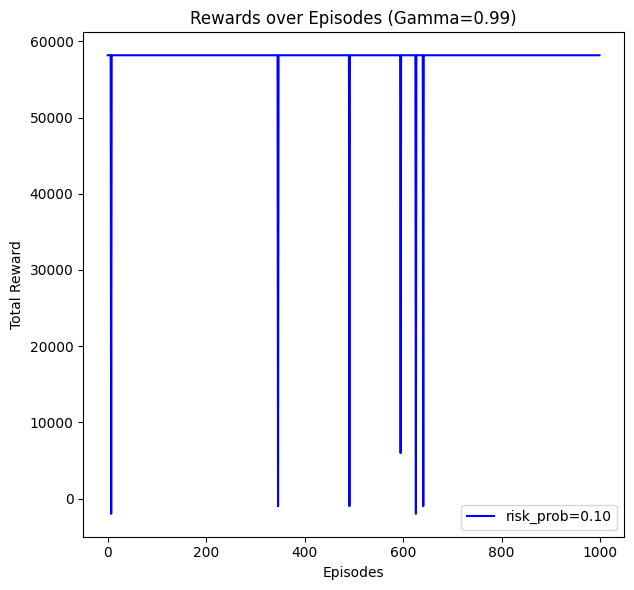

100%|██████████| 1000/1000 [01:12<00:00, 13.82it/s]


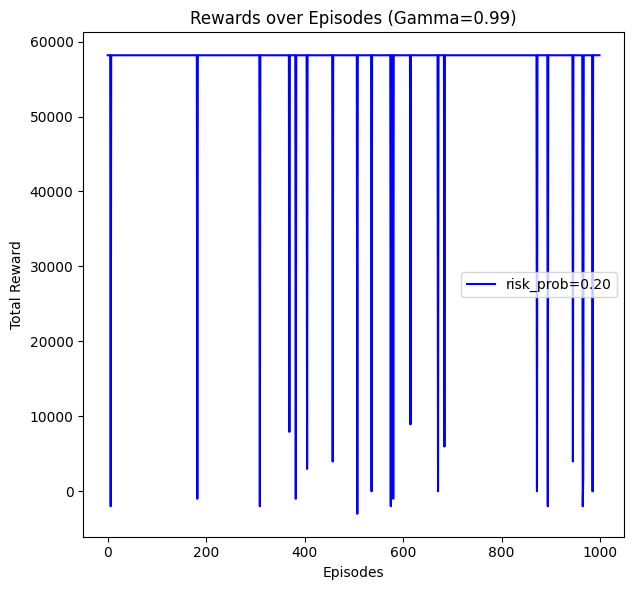

100%|██████████| 1000/1000 [01:09<00:00, 14.42it/s]


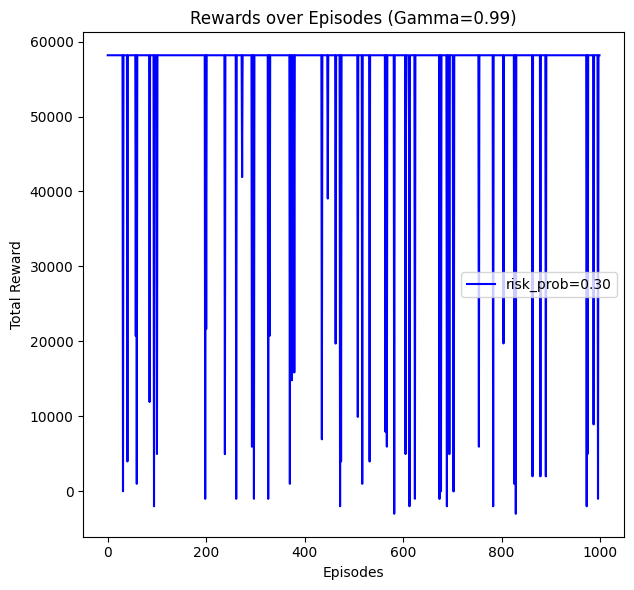

In [9]:
results = {}
for gamma in discount_factors:
    for risk_prob in risk_increment_probs:
        env = HealthcareEnv(risk_increment_prob=risk_prob)
        agent = HealthQLearnVFA(
            environment=env, learning_rate=learning_rate,
            epsilon=epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=gamma
        )
        env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
        rewards = []
        episode_lengths = []
        for episode in tqdm(range(n_episodes)):
            observation, info = env.reset()
            done = False
            total_reward = 0
            while not done:
                action = agent.policy(observation)
                s_prime, reward, terminated, truncated, info = env.step(action = action)
                #update
                agent.update(observation, action, reward, s_prime)
                done = terminated or truncated
                total_reward += reward
                observation = s_prime
            rewards.append(total_reward)
            episode_lengths.append(env.episode_lengths[-1])
            agent.decay_epsilon()
        results[(gamma, risk_prob)] = {
            'rewards': rewards,
            'episode_lengths': episode_lengths
        }

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(len(rewards)), rewards, label=f'risk_prob={risk_prob:.2f}', color='b')
        plt.title(f'Rewards over Episodes (Gamma={gamma})')
        plt.xlabel('Episodes')
        plt.ylabel('Total Reward')
        plt.legend()

        plt.tight_layout()
        plt.show()
        

## DQL

In [7]:
learning_rate = 0.001
n_episodes = 1000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes)  # reduce the exploration over time
final_epsilon = 0.1

In [ ]:
env = HealthcareEnv()  
state_size = 3  
action_size = env.action_space.n
DQL_agent = HealthcareDQL(state_size, action_size)

In [6]:
episodes = 30
batch_size = 64
target_update_frequency = 10

In [19]:
for episode in range(episodes):
    state = env.reset()[0]
    total_reward = 0
    done = False

    while not done:
        action = agent.act(np.array([state['budget'][0], state['health_level'], state['risk_level']]))
        next_state, reward, done, truncated, info = env.step(action)
        total_reward += reward
        agent.remember(np.array([state['budget'][0], state['health_level'], state['risk_level']]), action, reward, 
                       np.array([next_state['budget'][0], next_state['health_level'], next_state['risk_level']]), done)
        state = next_state

        if done:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2}")
            break

        # Train the agent using experience replay
        agent.replay(batch_size)

    # Update the target network every few episodes
    if episode % target_update_frequency == 0:
        agent.update_target_network()

Episode: 0, Total Reward: 59257, Epsilon: 1.0
Episode: 1, Total Reward: 59191, Epsilon: 0.76
Episode: 2, Total Reward: 59781, Epsilon: 0.56
Episode: 3, Total Reward: 60029, Epsilon: 0.42
Episode: 4, Total Reward: 60731, Epsilon: 0.31
Episode: 5, Total Reward: 59634, Epsilon: 0.23
Episode: 6, Total Reward: 61550, Epsilon: 0.17
Episode: 7, Total Reward: 60464, Epsilon: 0.13
Episode: 8, Total Reward: 61557, Epsilon: 0.095
Episode: 9, Total Reward: 61470, Epsilon: 0.071
Episode: 10, Total Reward: 61220, Epsilon: 0.053
Episode: 11, Total Reward: 60714, Epsilon: 0.039
Episode: 12, Total Reward: -3998, Epsilon: 0.039
Episode: 13, Total Reward: 59891, Epsilon: 0.029
Episode: 14, Total Reward: 60447, Epsilon: 0.022
Episode: 15, Total Reward: 59545, Epsilon: 0.016
Episode: 16, Total Reward: 60561, Epsilon: 0.012
Episode: 17, Total Reward: 60859, Epsilon: 0.01
Episode: 18, Total Reward: 59495, Epsilon: 0.01
Episode: 19, Total Reward: 60334, Epsilon: 0.01
Episode: 20, Total Reward: 59698, Epsilon:

### 2) Goal

###### The budget is not the priority, the priority is to minimize the health risk with a limited budget, we want to keep people safe now, not in a far future and your probability to stay in your place is proportional to the difference between health index and quality of the health care

In [27]:
state, info = env.reset()

for _ in range(30):
    state = np.array([state['budget'][0], state['health_level'], state['risk_level']])
    action = agent.act(state)
    s_prime, reward, terminated, truncated, info = env.step(action)
    print(f'Action: {action}', f'State: {state}', f'Reward: {round(reward,3)}', f'Terminated: {terminated}', truncated, info)

    if terminated or truncated:
        print(f'Final state: {s_prime}')
        print("End of simulation")
        state, info = env.reset()
        break
    else:
        state = s_prime
env.close()

Action: 1 State: [1000.   50.   50.] Reward: 500 Terminated: False False {}
Action: 2 State: [999.  50.  49.] Reward: 510 Terminated: False False {}
Action: 1 State: [1001.   50.   49.] Reward: 520 Terminated: False False {}
Action: 0 State: [1000.   50.   48.] Reward: 520 Terminated: False False {}
Action: 2 State: [998.  53.  48.] Reward: 1000 Terminated: False False {}
Action: 1 State: [1000.   53.   49.] Reward: 2500 Terminated: False False {}
Action: 2 State: [999.  53.  48.] Reward: 520 Terminated: False False {}
Action: 0 State: [1001.   53.   48.] Reward: 520 Terminated: False False {}
Action: 2 State: [999.  56.  48.] Reward: 520 Terminated: False False {}
Action: 0 State: [1001.   56.   48.] Reward: 999 Terminated: False False {}
Action: 1 State: [999.  59.  49.] Reward: 5500 Terminated: False False {}
Action: 1 State: [998.  59.  48.] Reward: 530 Terminated: False False {}
Action: 0 State: [997.  59.  47.] Reward: 530 Terminated: False False {}
Action: 2 State: [995.  62.  4